In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

2025-04-18 16:03:39.120 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


## Boilerplate usecase of Dino

Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


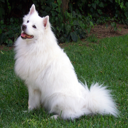

Predicted label: grey wolf (269)


In [3]:
from torchvision import models
from torchvision.transforms import Compose, Normalize, ToTensor

import requests
from IPython.display import display
from PIL import Image

# Load the pretrained DINO ViT-S/16 model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
model.eval()  # Set the model to evaluation mode

# Download a sample image from ImageNet
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")
display(img.resize((128, 128)))

imagenet_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image
input_tensor = imagenet_transform(img).unsqueeze(0)  # Add batch dimension

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Load ImageNet class labels
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = requests.get(imagenet_classes_url).json()

# Get the predicted label string
predicted_label = output.argmax(dim=1).item()
predicted_label_str = imagenet_classes[predicted_label]
print(f"Predicted label: {predicted_label_str} ({predicted_label})")

## Load data

In [4]:
from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    #RandomVerticalFlip(), # Dino was not pretrained with Vertical flip, lets avoid
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

In [5]:
# Hyper-parameters
BATCH_SIZE = 64
LR = 0.001

In [6]:
train_dataloader = DataLoader(cifar100_train)
test_dataloader = DataLoader(cifar100_test)

In [7]:
# Uncomment to extract mean and var
# WARNING: DO NOT RUN IF YOU APPLY OTHER TRANSOFRMATIONS THAN ToTensor()

# # Stack all images into a single tensor
# all_images = torch.cat([cifar100_train[i][0].unsqueeze(0) for i in range(len(cifar100_train))], dim=0)

# print(all_images.shape)

# # Calculate mean and std for each channel (RGB)
# mean = all_images.mean(dim=(0, 2, 3))  # Mean across batch, height, and width
# std = all_images.std(dim=(0, 2, 3))    # Std across batch, height, and width

# print(f"Mean: {mean}")
# print(f"Std: {std}")

## Train Model

In [8]:
from models import BaseDino

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = BaseDino()
model.to(device)

Using device: cuda


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


BaseDino(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((3

In [9]:
model.get_config()

{'variant': 'dino_vits16',
 'dropout_rate': 0.1,
 'head_hidden_size': 1024,
 'head_layers': 5,
 'num_classes': 100,
 'unfreeze_blocks': 3}

In [10]:
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=LR)
# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5) # Numb of epochs non relevant
# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Preallocated lists: if the training interrupts, it will still save their values
all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]     # Pre-allocated list for validation losses
all_training_accuracies=[]   # Pre-allocated list for training accuracies
all_validation_accuracies=[] # Pre-allocated list for validation accuracies

In [12]:

# Train the model and save periodically
# NOTE: If a checkpoint with the exact same model name, 
# model class and epoch number exists, it will be overwritten!!!
_, _, _, _ = train(
    checkpoint_dir=CHECKPOINT_DIR,
    name="arceus", # If empty, will automatically find a name for the model
    start_epoch=1, # Try one epoch
    num_epochs=1, # Try one epoch
    save_every=1, # Try one epoch
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    model=model, # Use the same model as before (partially pre-trained)
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    verbose=False,
    all_training_losses=all_training_losses,  # Pre-allocated list for training losses
    all_validation_losses=all_validation_losses,  # Pre-allocated list for validation losses
    all_training_accuracies=all_training_accuracies,  # Pre-allocated list for training accuracies
    all_validation_accuracies=all_validation_accuracies,  # Pre-allocated list for validation accuracies
)

Prefix/name for the model was provided: arceus

🚀 Epoch 1/1 (100.00%) Completed
	📊 Training Loss: 3.2774
	✅ Training Accuracy: 21.95%
	⏳ Elapsed Time: 443.93s | ETA: 0.00s
	🕒 Completed At: 16:13
🔍 Validation Results:
	📉 Validation Loss: 2.9671
	🎯 Validation Accuracy: 31.16%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arceus_BaseDino_epoch_1.pth



In [16]:
# Load the model from a checkpoint
model_class = BaseDino
# NOTE: If you do not specify a file name, it will automatically find the latest checkpoint
checkpoint_path = f"{CHECKPOINT_DIR}/{model_class.__name__}/arceus_{model_class.__name__}_epoch_1.pth"

# Pass device also here to directly load the state dict (not the model itself!) on the device
model, start_epoch = load(path=checkpoint_path, model_class=model_class, verbose=True)
model.to(device)  # Move model to the device, for real this time!

🔍 Loading checkpoint from /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arceus_BaseDino_epoch_1.pth
📦 Model class in checkpoint: BaseDino
⚙️ Optimizer class in checkpoint: SGD
📈 Scheduler class in checkpoint: CosineAnnealingLR
🔧 Model configuration: {'variant': 'dino_vits16', 'dropout_rate': 0.1, 'head_hidden_size': 1024, 'head_layers': 5, 'num_classes': 100, 'unfreeze_blocks': 3}


Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


✅ Loaded checkpoint from /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arceus_BaseDino_epoch_1.pth, resuming at epoch 2


BaseDino(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.1, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.1, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (norm): LayerNorm((3

In [18]:
# Resume training
_, _, _, _ = train(
    checkpoint_dir=CHECKPOINT_DIR,
    name="arceus", # Use the same name, or just a different one if you are afraid of overwriting!
    start_epoch=start_epoch, # Resume from the correct epoch
    num_epochs=3, 
    save_every=1, 
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    model=model, # Use the same model as before (partially pre-trained)
    criterion=criterion,
    optimizer=optimizer,  # I could also change the optimizer if I wanted to!
    scheduler=scheduler,
    verbose=False,
    all_training_losses=all_training_losses,  # Will not overwrite the original, but just append
    all_validation_losses=all_validation_losses,
    all_training_accuracies=all_training_accuracies,
    all_validation_accuracies=all_validation_accuracies,
)

Prefix/name for the model was provided: arceus

🚀 Epoch 2/4 (50.00%) Completed
	📊 Training Loss: 2.8595
	✅ Training Accuracy: 29.40%
	⏳ Elapsed Time: 482.98s | ETA: 965.96s
	🕒 Completed At: 16:38
🔍 Validation Results:
	📉 Validation Loss: 2.9671
	🎯 Validation Accuracy: 31.16%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arceus_BaseDino_epoch_2.pth

🚀 Epoch 3/4 (75.00%) Completed
	📊 Training Loss: 2.8591
	✅ Training Accuracy: 29.39%
	⏳ Elapsed Time: 497.43s | ETA: 497.43s
	🕒 Completed At: 16:47
🔍 Validation Results:
	📉 Validation Loss: 2.9671
	🎯 Validation Accuracy: 31.16%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/BaseDino/arceus_BaseDino_epoch_3.pth



KeyboardInterrupt: 

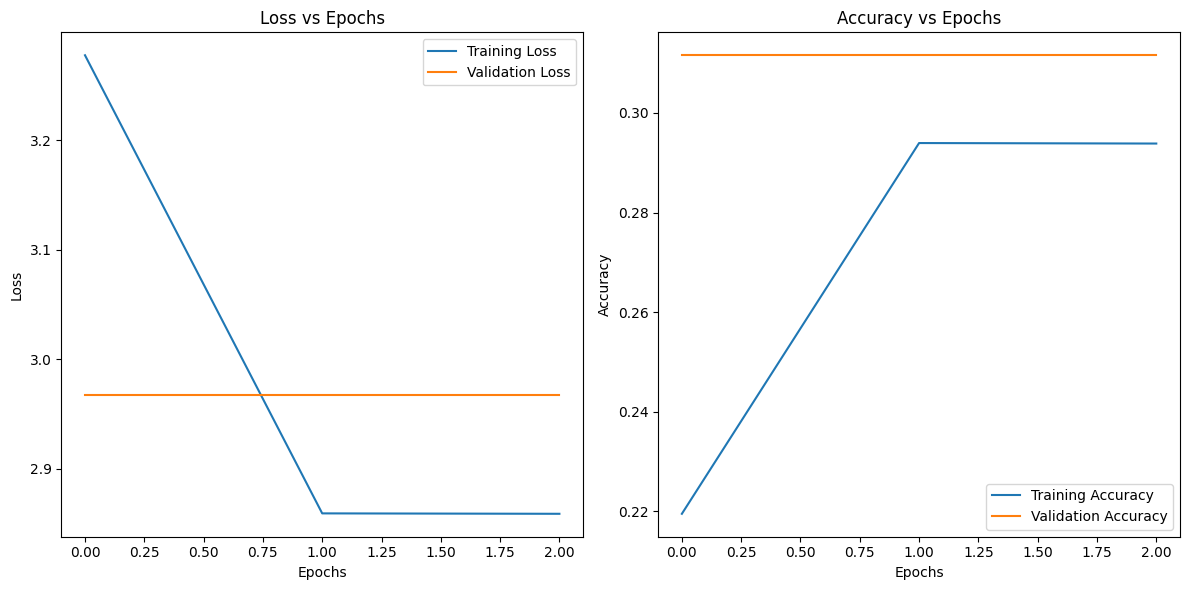

In [19]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()